In [91]:
import pandas as pd
import numpy as np
import os 


import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
import seaborn as sns 

from tqdm import tqdm

In [92]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

In [93]:
from sklearn.linear_model import ElasticNet, LogisticRegression

In [94]:
print(pd.__version__)

1.5.3


In [95]:
RANDOM_SEED = 921

In [96]:
plot_params = {
    'font.family': 'Times',
    'font.weight': 'light',
    
    'figure.figsize': (15,15),
    'figure.frameon': False, 
    'figure.titlesize': 'xx-large',
    'figure.titleweight': 'normal',
    
    'axes.titlesize': 'x-large',
    'axes.titlecolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlelocation': 'center',
    'axes.labelsize': 'x-large',

    'grid.alpha': .25, 
    'legend.frameon':False,
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
}

pylab.rcParams.update(plot_params)
sns.set_palette('mako')

In [97]:
data_folder = 'data'
train_data_path = 'train.csv'
test_data_path = 'test.csv'
sample_submission_path = 'sample_submission.csv'

In [98]:
train_path = os.path.join(data_folder, train_data_path)
test_path = os.path.join(data_folder, test_data_path)
sample_path = os.path.join(data_folder, sample_submission_path)

In [99]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_path)

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117564 entries, 0 to 117563
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    117564 non-null  int64  
 1   Mean_Integrated       117564 non-null  float64
 2   SD                    117564 non-null  float64
 3   EK                    117564 non-null  float64
 4   Skewness              117564 non-null  float64
 5   Mean_DMSNR_Curve      117564 non-null  float64
 6   SD_DMSNR_Curve        117564 non-null  float64
 7   EK_DMSNR_Curve        117564 non-null  float64
 8   Skewness_DMSNR_Curve  117564 non-null  float64
 9   Class                 117564 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 9.0 MB


In [101]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,117564.0,58781.500000,33937.947861,0.000000,29390.750000,58781.500000,88172.250000,117563.000000
Mean_Integrated,117564.0,111.248300,24.906474,6.054688,104.546875,116.664062,126.296875,189.367188
SD,117564.0,46.713535,6.102941,24.783273,43.443390,47.478932,50.862718,93.602933
EK,117564.0,0.503498,1.127093,-1.730782,0.049761,0.186498,0.395620,7.879628
Skewness,117564.0,1.886385,6.515466,-1.791886,-0.188956,0.091720,0.691613,65.385974
Mean_DMSNR_Curve,117564.0,11.962921,26.719946,0.213211,2.090301,2.808528,4.122910,217.371238
SD_DMSNR_Curve,117564.0,26.190678,20.041937,7.370432,14.955405,18.164924,24.732218,109.890785
EK_DMSNR_Curve,117564.0,8.037488,3.840980,-2.597872,6.742911,8.442883,10.003237,34.539844
Skewness_DMSNR_Curve,117564.0,93.881076,79.962110,-1.976976,49.409136,83.421375,122.093290,1191.000837
Class,117564.0,0.093285,0.290833,0.000000,0.000000,0.000000,0.000000,1.000000


In [102]:
feature_columns = train.drop(['Class', 'id'], axis=1).columns.tolist()

In [103]:
feature_columns

['Mean_Integrated',
 'SD',
 'EK',
 'Skewness',
 'Mean_DMSNR_Curve',
 'SD_DMSNR_Curve',
 'EK_DMSNR_Curve',
 'Skewness_DMSNR_Curve']

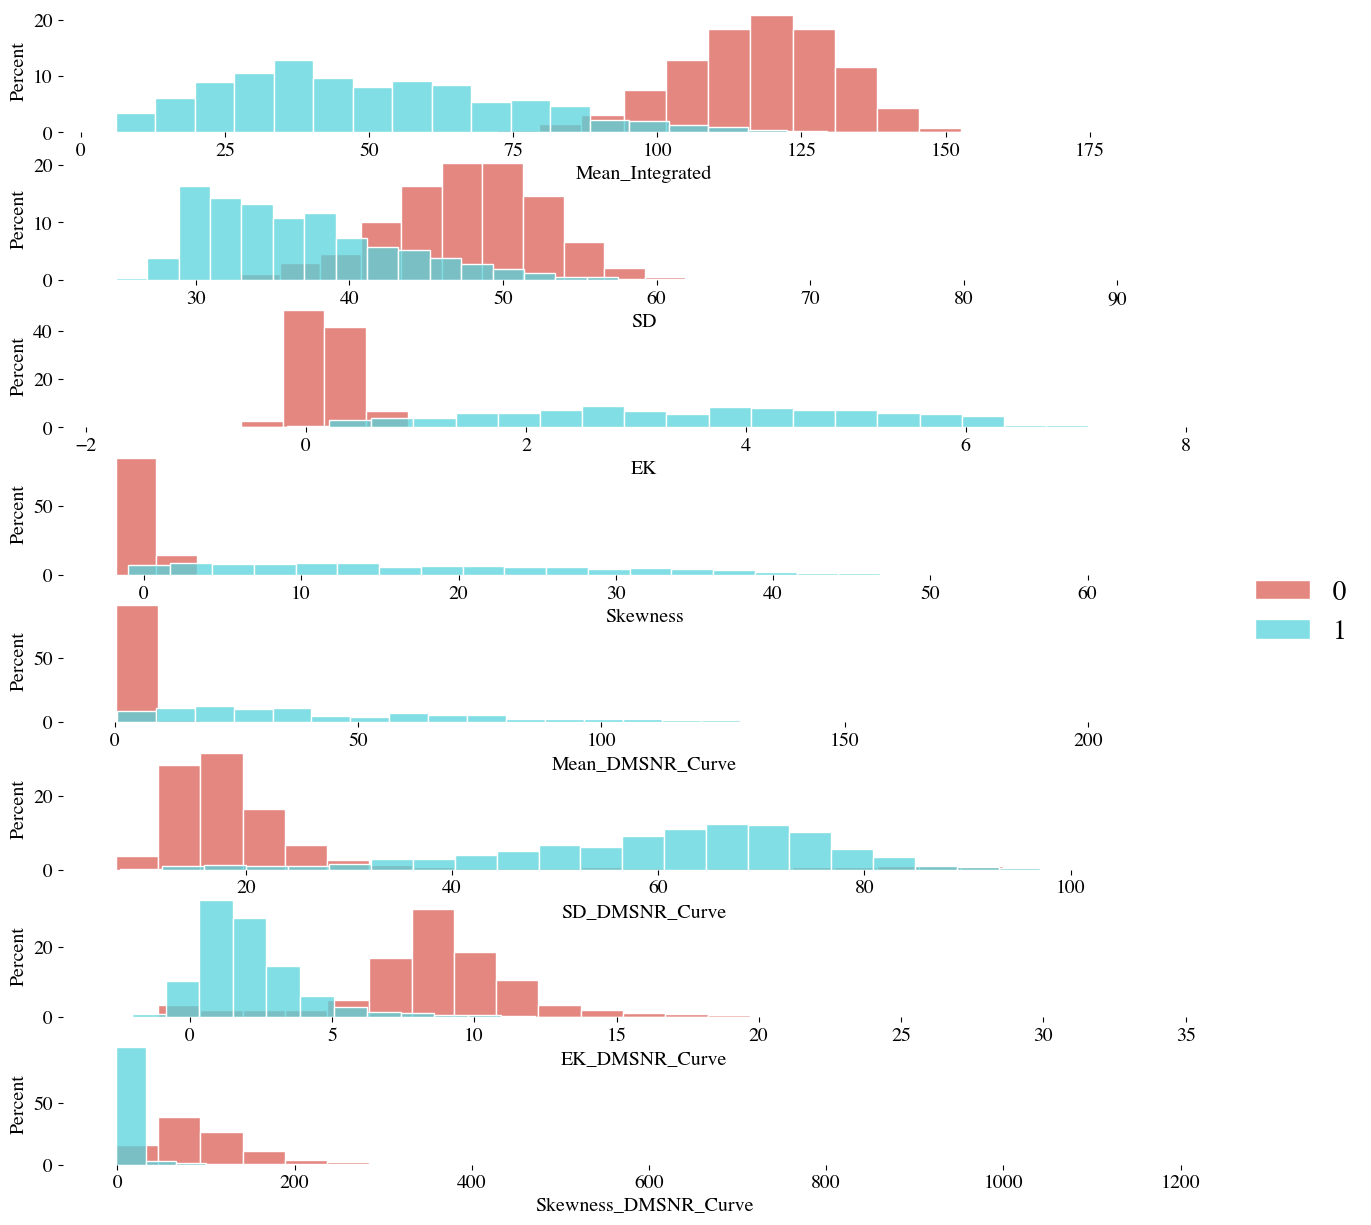

In [104]:
fig, axs = plt.subplots(ncols=1, nrows=len(feature_columns))
axs = axs.flatten()
for col, ax in zip(feature_columns, axs):
    sns.histplot(train.loc[train.Class == 0][col], ax = ax, bins = 25, stat = 'percent', color = sns.color_palette("hls", 8)[0], edgecolor = 'white', label = '0')
    sns.histplot(train.loc[train.Class == 1][col], ax = ax, bins = 25, stat = 'percent', color = sns.color_palette("hls", 8)[4], edgecolor = 'white', label = '1')
    ax.set_frame_on(False)
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc = 'center right', prop = {'size': 20})

8it [00:01,  4.07it/s]


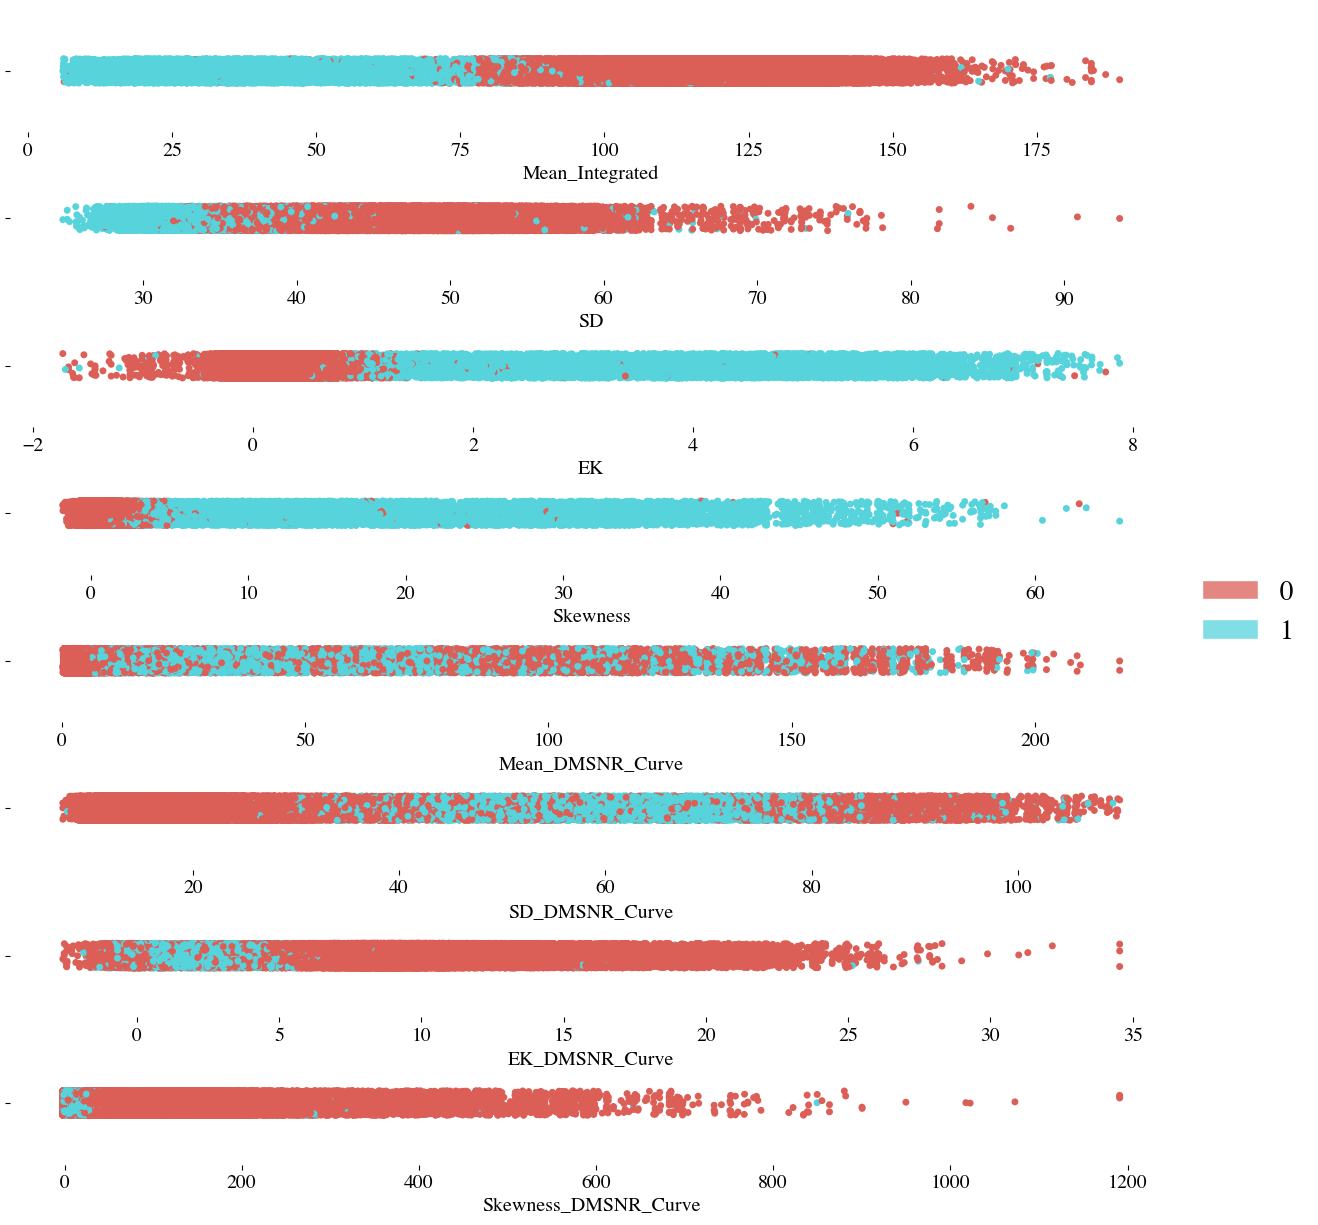

In [105]:
fig, axs = plt.subplots(ncols=1, nrows=len(feature_columns))
axs = axs.flatten()
for col, ax in tqdm(zip(feature_columns, axs)):
    sns.stripplot(data = train, x = col, hue = 'Class',  ax = ax, legend=False, palette='hls')
    ax.set_frame_on(False)


fig.legend(handles, labels, loc = 'center right', prop = {'size': 20})
plt.show()

In [106]:
x, y = train.drop('Class', axis = 1), train.Class

In [107]:
from xgboost import XGBClassifier
from sklearn.isotonic import IsotonicRegression

In [108]:
config = {'SEED': RANDOM_SEED,
          'FOLDS': 5,
          'N_ESTIMATORS': 700}

params = {'max_depth': 4,
          'learning_rate': 0.06,
          'colsample_bytree': 0.67,
          'n_jobs': -1,
          'objective': 'binary:logistic',
          'early_stopping_rounds': 150,
          'verbosity': 0,
          'eval_metric': 'logloss'}

In [109]:
stratified_k = StratifiedKFold(n_splits=3, random_state=RANDOM_SEED, shuffle=True)

In [114]:
model = XGBClassifier(objective= 'binary:logistic')
metrics = []
for fold_idx, (train_idxs, test_idxs) in enumerate(stratified_k.split(x, y)):
    x_train, x_valid = x.loc[train_idxs], x.loc[test_idxs]
    y_train, y_valid = y.loc[train_idxs], y.loc[test_idxs]

    model.fit(x_train, y_train)

    y_preds = model.predict(x_valid)
    metric = log_loss(x_valid, y_preds)

    print(f"\tFold {fold_idx + 1}: {metric}")
    

ValueError: Multioutput target data is not supported with label binarization

In [115]:
preds = model.predict(test)

In [116]:
preds

array([0, 0, 0, ..., 0, 0, 1])

In [119]:
preds.shape

(78377,)

In [118]:
sample_submission

,id,Class
0,117564,0.5
1,117565,0.5
2,117566,0.5
3,117567,0.5
4,117568,0.5
...,...,...
78372,195936,0.5
78373,195937,0.5
78374,195938,0.5
78375,195939,0.5


In [120]:
sample_submission['Class'] = preds

In [122]:
sample_submission.to_csv('baseline.csv')